In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pycocotools
!pip install matplotlib


Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124


In [2]:
# Gỡ numpy hiện tại
!pip uninstall -y numpy

# Cài numpy phiên bản phổ biến, ổn định, ví dụ 1.24.4
!pip install numpy==1.24.4

# Cài lại PyTorch (phiên bản phù hợp Colab hiện tại)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

# Sau khi cài xong, restart runtime bằng tay (Runtime > Restart runtime)


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 113.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import os

DATA_DIR = '/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang'  # Đổi nếu bạn dùng nơi khác
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')

print(os.listdir(DATA_DIR))


['README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


In [3]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cpu
    Uninstalling torch-2.6.0+cpu:
      Successfully uninstalled torch-2.6.0+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torchaudio-2.6.0+cu124:
      Successfully uninstalled torchaudio-2.6.0+cu124


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance(num_classes):
    # Load model Faster R-CNN pre-trained trên COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Lấy số feature input cho classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Thay bộ phân lớp box predictor bằng bộ mới với đúng số class của bạn
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [5]:
from pycocotools.coco import COCO
import torch
import os
import numpy as np
from PIL import Image
import torchvision.transforms as T

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Lọc annotation có segmentation hợp lệ (polygon đủ điểm)
        valid_anns = []
        for ann in anns:
            segm = ann.get('segmentation', [])
            if segm and all(len(poly) >= 6 for poly in segm if isinstance(poly, list)):
                valid_anns.append(ann)
            else:
                pass

        # Load ảnh
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img_path = os.path.join(self.img_dir, path)
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        masks = []

        for ann in valid_anns:
            bbox = ann['bbox']  # [x_min, y_min, width, height]
            x_min, y_min, w, h = bbox
            boxes.append([x_min, y_min, x_min + w, y_min + h])
            labels.append(ann['category_id'])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)  # shape (num_objs, H, W)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


def get_transform():
    transforms = []
    transforms.append(T.ToTensor())  # Chuyển ảnh sang tensor, giữ nguyên size 640x640
    return T.Compose(transforms)


In [6]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T

# Đường dẫn dữ liệu
TRAIN_IMG_DIR = "/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang/train"
TRAIN_ANN_PATH = "/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang/train/_annotations.coco.json"

VAL_IMG_DIR = "/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang/valid"
VAL_ANN_PATH = "/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang/valid/_annotations.coco.json"

# Transform đơn giản (chỉ ToTensor)
transform = T.Compose([
    T.ToTensor()
])

# Tạo dataset (bạn phải định nghĩa trước class CocoDataset)
train_dataset = CocoDataset(
    TRAIN_IMG_DIR,
    TRAIN_ANN_PATH,
    transforms=transform
)

val_dataset = CocoDataset(
    VAL_IMG_DIR,
    VAL_ANN_PATH,
    transforms=transform
)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        collate_fn=lambda x: tuple(zip(*x)))

# Khởi tạo mô hình (4 classes: MR, NC, WR, + background)
num_classes = 4
model = get_model_instance(num_classes)


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 156MB/s]


In [7]:
import torch
import time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    for i, (imgs, targets) in enumerate(train_loader):
        # Loại bỏ các targets không hợp lệ (ví dụ không có bbox)
        filtered_imgs = []
        filtered_targets = []
        for img, target in zip(imgs, targets):
            if target['boxes'].numel() > 0:  # kiểm tra có bbox không
                filtered_imgs.append(img)
                filtered_targets.append(target)
        if len(filtered_imgs) == 0:
            # Nếu toàn bộ batch không có annotation, bỏ qua batch
            continue

        imgs = list(img.to(device) for img in filtered_imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in filtered_targets]

        optimizer.zero_grad()
        try:
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            running_loss += losses.item()
        except Exception as e:
            print(f"Warning: skipping batch {i} due to error: {e}")
            continue

        if (i + 1) % 10 == 0:
            avg_loss = running_loss / 10
            elapsed = time.time() - start_time
            print(f"[Epoch {epoch+1}/{num_epochs}] Step {i+1}, Avg Loss: {avg_loss:.4f}, Time per 10 steps: {elapsed:.2f}s")
            running_loss = 0.0
            start_time = time.time()

    lr_scheduler.step()

print("Training complete.")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training complete.


In [8]:
import torch
import time
import json
import os
import numpy as np
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# --- Load model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# --- Đường dẫn file annotation gốc ---
annotation_path = '/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang/valid/_annotations.coco.json'
coco_gt = COCO(annotation_path)

# --- Đánh giá model ---
all_predictions = []
inference_times = []

image_ids = []

with torch.no_grad():
    for imgs, targets in tqdm(val_loader, desc="Running inference"):
        imgs = [img.to(device) for img in imgs]

        start_time = time.time()
        outputs = model(imgs)
        end_time = time.time()

        inference_times.append((end_time - start_time) / len(imgs))

        for i, output in enumerate(outputs):
            image_id = targets[i]['image_id'].item()
            boxes = output['boxes'].cpu()
            scores = output['scores'].cpu()
            labels = output['labels'].cpu()

            keep = scores > 0.5
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box.tolist()
                width = x2 - x1
                height = y2 - y1
                all_predictions.append({
                    'image_id': image_id,
                    'category_id': int(label.item()),
                    'bbox': [x1, y1, width, height],
                    'score': float(score.item())
                })

            image_ids.append(image_id)

# --- Lưu kết quả dự đoán vào file tạm để dùng cho COCOeval ---
predictions_path = 'temp_predictions.json'
with open(predictions_path, 'w') as f:
    json.dump(all_predictions, f, indent=2)

# --- Load lại prediction dưới dạng COCO ---
coco_dt = coco_gt.loadRes(predictions_path)

# --- Đánh giá bằng COCOeval ---
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.params.imgIds = image_ids
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# --- In tốc độ inference ---
avg_time = np.mean(inference_times)
print(f"\n🚀 Inference time: {avg_time*1000:.2f} ms/image ({1.0/avg_time:.2f} FPS)")

# --- Tính kích thước model ---
torch.save(model.state_dict(), "temp_model.pth")
model_size = os.path.getsize("temp_model.pth") / (1024 * 1024)
print(f"💾 Model size: {model_size:.2f} MB")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Running inference: 100%|██████████| 57/57 [05:11<00:00,  5.47s/it]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

<ipython-input-9-a99253ed7ef5>:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


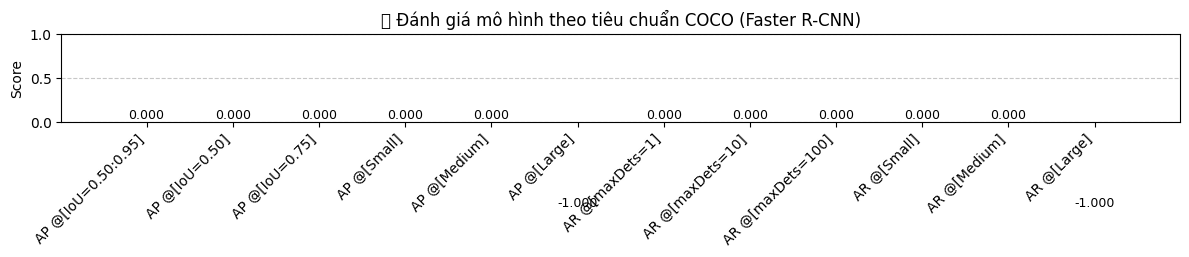

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# coco_eval đã được tạo và đã chạy .evaluate(), .accumulate(), .summarize()
# coco_eval.stats: chứa 12 chỉ số đánh giá tiêu chuẩn COCO

metrics = [
    "AP @[IoU=0.50:0.95]",
    "AP @[IoU=0.50]",
    "AP @[IoU=0.75]",
    "AP @[Small]",
    "AP @[Medium]",
    "AP @[Large]",
    "AR @[maxDets=1]",
    "AR @[maxDets=10]",
    "AR @[maxDets=100]",
    "AR @[Small]",
    "AR @[Medium]",
    "AR @[Large]",
]

values = coco_eval.stats

plt.figure(figsize=(12, 6))
bars = plt.bar(metrics, values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.title('📊 Đánh giá mô hình theo tiêu chuẩn COCO (Faster R-CNN)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gắn giá trị cụ thể lên đầu cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import time
import os
from collections import Counter
from torchvision.utils import draw_bounding_boxes
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Đo inference time
inference_times = []
all_predictions = []
all_targets = []

# Giả sử bạn đã có val_loader
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = list(img.to(device) for img in imgs)

        start = time.time()
        outputs = model(imgs)
        end = time.time()

        inference_times.append((end - start) / len(imgs))  # ms/ảnh

        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu()
            scores = output['scores'].cpu()
            labels = output['labels'].cpu()

            # Filter theo threshold
            keep = scores > 0.5
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            # Lưu để đánh giá (giả sử có dùng COCO)
            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box.tolist()
                width = x2 - x1
                height = y2 - y1
                all_predictions.append({
                    "image_id": targets[i]["image_id"].item(),
                    "category_id": label.item(),
                    "bbox": [x1, y1, width, height],
                    "score": score.item()
                })

        break  # test 1 batch cho nhanh, bỏ nếu muốn đầy đủ

# ----- Nếu có annotation COCO gốc -----
# coco_gt = COCO('path/to/val/_annotations.coco.json')
# coco_dt = coco_gt.loadRes(all_predictions)
# coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()
# => In ra mAP, IoU, Precision...

# ---- In tốc độ inference ----
avg_time = np.mean(inference_times)
fps = 1.0 / avg_time
print(f"\n🚀 Inference time: {avg_time * 1000:.2f} ms/image ({fps:.2f} FPS)")

# ---- Kích thước model ----
model_path = "model.pth"
torch.save(model.state_dict(), model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"💾 Model size: {model_size:.2f} MB")



🚀 Inference time: 9459.83 ms/image (0.11 FPS)
💾 Model size: 168.08 MB


Tổng số phát hiện: 12
MR: 12 con


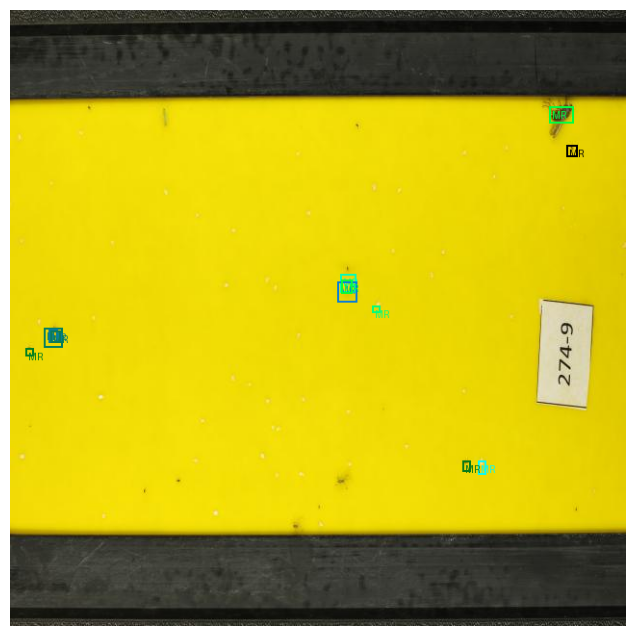

In [ ]:
import torch
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load ảnh
image_path = "/content/drive/MyDrive/du_lieu_bay_vang/datasets/bayvang/train/1000_jpg.rf.5969cb3d08b915d2cc620821a046bcb3.jpg"
image = Image.open(image_path).convert("RGB")

# Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.ToTensor(),  # chuyển ảnh về tensor [C, H, W], giá trị [0,1]
])
img_tensor = transform(image).to(torch.device('cuda') if torch.cuda.is_available() else 'cpu')

# Thêm batch dimension
img_batch = [img_tensor]

# Đảm bảo model ở chế độ eval
model.eval()

# Inference
with torch.no_grad():
    outputs = model(img_batch)

# Lấy kết quả
output = outputs[0]
boxes = output['boxes']
labels = output['labels']
scores = output['scores']

# Lọc theo score threshold
threshold = 0.5
keep = scores > threshold
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]

# Đổi nhãn sang tên
class_names = {1: 'MR', 2: 'NC', 3: 'WR'}
label_names = [class_names.get(label.item(), str(label.item())) for label in labels]

# Đếm số lượng từng loài
count_per_class = Counter(label_names)

# In kết quả
print("Tổng số phát hiện:", len(label_names))
for cls_name, count in count_per_class.items():
    print(f"{cls_name}: {count} con")

# Vẽ kết quả
img_uint8 = (img_tensor * 255).byte()
img_with_boxes = draw_bounding_boxes(img_uint8.cpu(), boxes.cpu(), labels=label_names, width=2)

# Hiển thị
npimg = img_with_boxes.permute(1, 2, 0).numpy()
plt.figure(figsize=(12, 8))
plt.imshow(npimg)
plt.axis('off')
plt.show()
